---
---

# Lumi decrease

In [32]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import pandas as pd
import glob
import sys
sys.path.append('../')

# Make sure this import is after pandas
import Backend.ABPPandas

import Backend.Constants as cst
import Backend.NXCALS as nx


# Matplotlib config
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"


# Creating NXCALS variable containers
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]

buckets   = np.arange(3564)

# Locating data
DATA_PATH = '/eos/project/l/lhc-lumimod/LuminosityFollowUp/2022_test_v0.2.2/'
BMODE     = None#'STABLE'

def importData(_fill,columns):
    # Importing fill data
    df = pd.read_parquet(DATA_PATH+f'HX:FILLN={FILL}',columns=columns)
    df = df.sort_index()
    df.index.name = 'unix'
    df.insert(0,'Timestamp',df.index)
    df.insert(1,'Time',1e-9*(df.index - df.index[0]))
    df['Timestamp'] = df['Timestamp'].apply(lambda t: pd.Timestamp(t).tz_localize('UTC'))
    return df

def wireROI(df):
    wire_start = df[df[wires['B1'][0]['I']]>10]['Timestamp'].min()
    wire_stop  = df[(df[wires['B1'][0]['I']]>295)&(df['Timestamp']>wire_start)]['Timestamp'].min()
    wire_start,wire_stop = wire_start-pd.Timedelta(minutes=3),wire_stop+pd.Timedelta(minutes=3)
    return wire_start,wire_stop

def getFilledBuckets(df,beam):

    filled_ts = np.min(df[df[beam['Intensity']]== np.max(df[beam['Intensity']])].index)


    sub = df.dropna(subset=[beam['bb_Intensity']])
    _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
    bunch_I   = df.loc[_ts,beam['bb_Intensity']]
    return bunch_I


## Xsection

8103


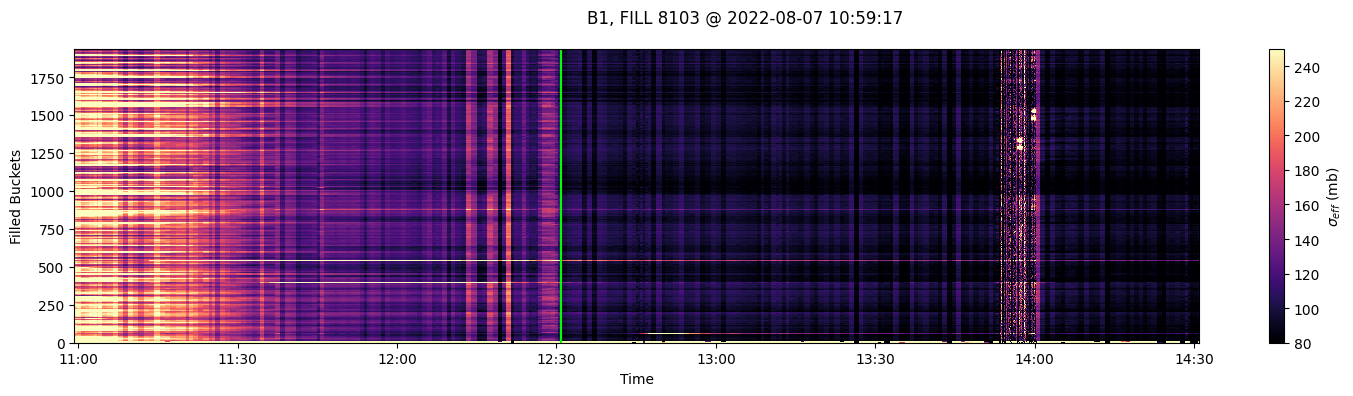

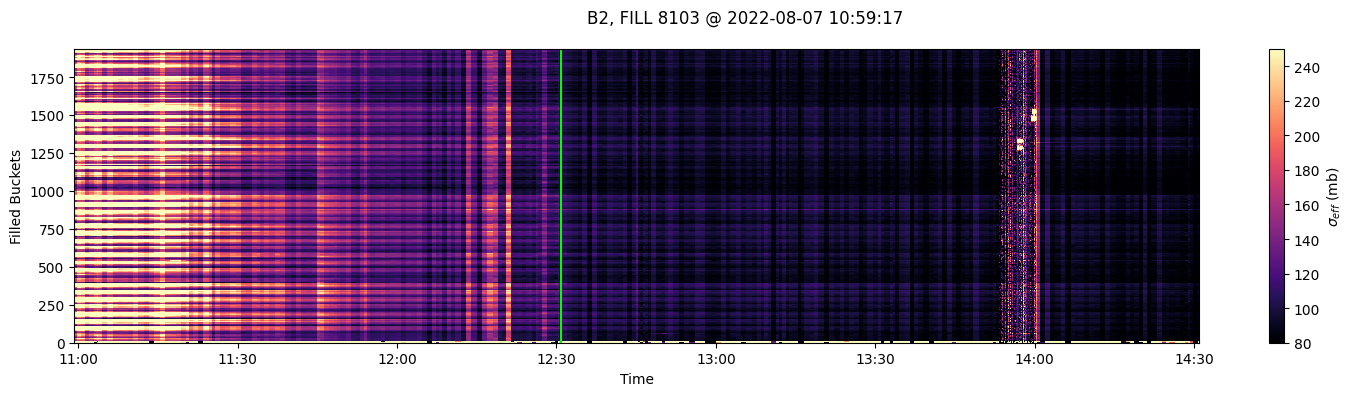

In [55]:

vmin = 80
vmax = 250

fills_info       = pd.read_pickle("wires_on.pkl")
fills_to_analyze = list(fills_info.index) 

fills_to_analyze =[8103]

for FILL in fills_to_analyze:
    print(FILL)
    plt.close('all')
    for beam in beams:
        fig = plt.figure(figsize=(15,4))

        # Importing some data for timescales
        #-----------------------------------
        database             = importData(FILL,columns=['HX:BMODE']+[wire.I for wire in wires['B1']+wires['B2']] + [beam['Intensity'] for beam in beams] + [beam['bb_Intensity'] for beam in beams])
        wire_start,wire_stop = wireROI(database)
        bunch_I              = getFilledBuckets(database,beam)
        filled_buckets = np.arange(len(buckets))[bunch_I!=0]

        start_ts = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
        stop_ts  = wire_stop+pd.Timedelta(hours=2)
        plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')
        #-----------------------------------
        
        # Loading Xsection
        #-----------------------------------
        lifetime_df = pd.read_pickle(f"../Results_Lumi_bb/pkl_per_fill/Xsection_F{FILL}_{beam.name}.pkl")    
        times,datagrid = lifetime_df.set_index('Timestamp')['sig_c'].to_2D()
        #-----------------------------------

        # Plotting
        #------------------------------------
        datagrid = datagrid[:,filled_buckets]
        plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/1e-3,vmin=vmin,vmax=vmax,cmap='magma')
        plt.axvline(wire_start,color='lime')
        plt.axvline(wire_stop,color='lime')
        #------------------------------------
        cbar = plt.colorbar()
        cbar.set_label(r'$\sigma_{eff}$ (mb)')
        plt.ylabel('Filled Buckets')
        plt.xlabel('Time')
        plt.xlim([start_ts,stop_ts])

        plt.tight_layout()
        #plt.savefig(f'../Results_Lumi_bb/LBOC_plots/xsection_F{FILL}_{beam.name}.png',dpi=300)

# Diff of xsection

8146


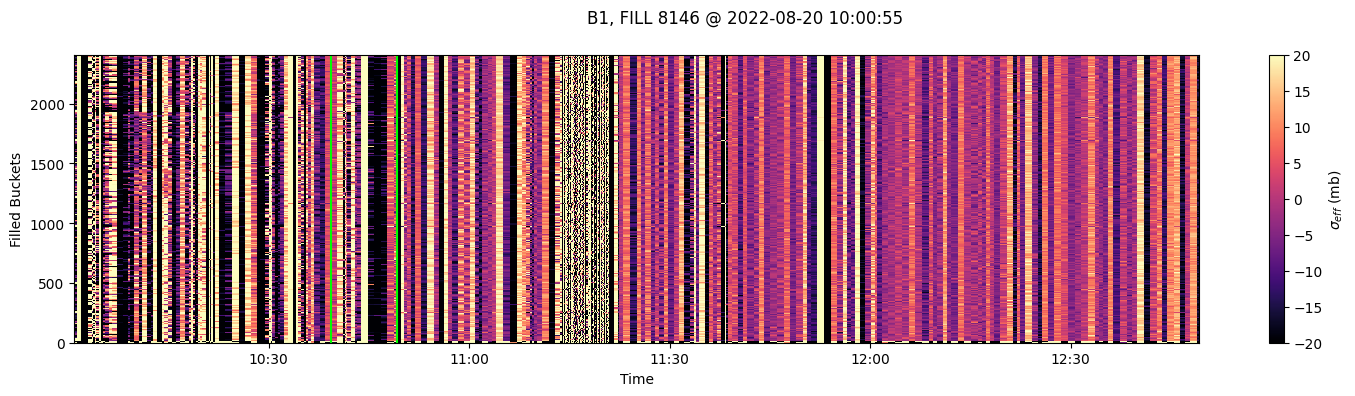

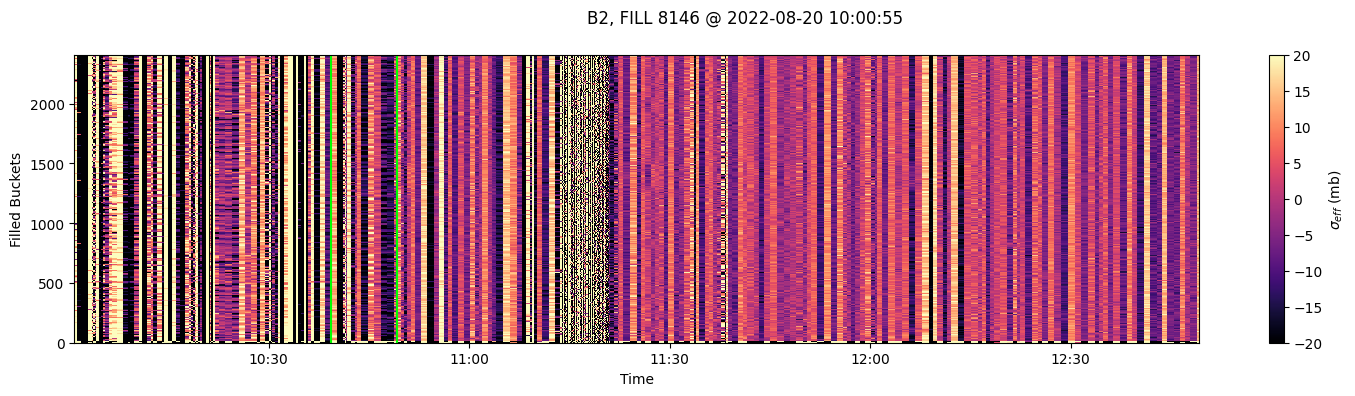

In [59]:
import matplotlib.colors as colors

vmin = -20
vmax = 20

fills_info       = pd.read_pickle("wires_on.pkl")
fills_to_analyze = list(fills_info.index) 

fills_to_analyze =[8146]

for FILL in fills_to_analyze:
    print(FILL)
    plt.close('all')
    for beam in beams:
        fig = plt.figure(figsize=(15,4))

        # Importing some data for timescales
        #-----------------------------------
        database             = importData(FILL,columns=['HX:BMODE']+[wire.I for wire in wires['B1']+wires['B2']] + [beam['Intensity'] for beam in beams] + [beam['bb_Intensity'] for beam in beams])
        wire_start,wire_stop = wireROI(database)
        bunch_I              = getFilledBuckets(database,beam)
        filled_buckets = np.arange(len(buckets))[bunch_I!=0]

        start_ts = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
        stop_ts  = wire_stop+pd.Timedelta(hours=2)
        plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')
        #-----------------------------------
        
        # Loading Xsection
        #-----------------------------------
        lifetime_df = pd.read_pickle(f"../Results_Lumi_bb/pkl_per_fill/Xsection_F{FILL}_{beam.name}.pkl")    
        times,datagrid = lifetime_df.set_index('Timestamp')['sig_c'].to_2D()
        #-----------------------------------
        datagrid = np.diff(datagrid,axis=0)

        # Plotting
        #------------------------------------
        datagrid = datagrid[:,filled_buckets]
        plt.pcolormesh(times[:-1], np.arange(np.shape(datagrid)[1]), datagrid.T/1e-3,vmin=vmin,vmax=vmax,cmap='magma')

        #plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/1e-3, norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='magma')
        plt.axvline(wire_start,color='lime')
        plt.axvline(wire_stop,color='lime')
        #------------------------------------
        cbar = plt.colorbar()
        cbar.set_label(r'$\sigma_{eff}$ (mb)')
        plt.ylabel('Filled Buckets')
        plt.xlabel('Time')
        plt.xlim([start_ts,stop_ts])

        plt.tight_layout()
        #plt.savefig(f'../Results_Lumi_bb/LBOC_plots/xsection_F{FILL}_{beam.name}.png',dpi=300)

# Tunes

8033
8063
8072
8076
8081
8083
8088
8094
8102
8103
8112
8113
8115
8118
8120
8124
8128
8132
8136
8142
8143
8146


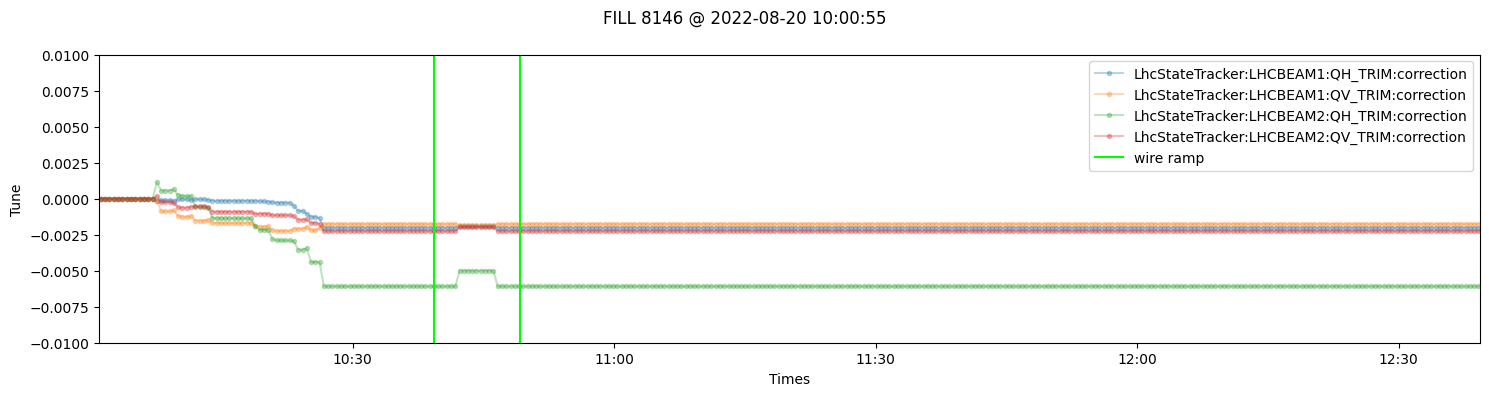

In [54]:


fills_info       = pd.read_pickle("wires_on.pkl")
fills_to_analyze = list(fills_info.index) 


tune_vars = ['LhcStateTracker:LHCBEAM1:QH_TRIM:correction',
           'LhcStateTracker:LHCBEAM1:QV_TRIM:correction',
           'LhcStateTracker:LHCBEAM2:QH_TRIM:correction',
           'LhcStateTracker:LHCBEAM2:QV_TRIM:correction']

for FILL in fills_to_analyze:
    print(FILL)
    plt.close('all')

    fig = plt.figure(figsize=(15,4))

    # Importing some data for timescales
    #-----------------------------------
    database             = importData(FILL,columns=tune_vars + ['HX:BMODE']+[wire.I for wire in wires['B1']+wires['B2']] )
    wire_start,wire_stop = wireROI(database)

    start_ts = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
    stop_ts  = wire_start+pd.Timedelta(hours=2)
    plt.suptitle(f'FILL {FILL} @ {str(start_ts)[:19]}')
    #-----------------------------------




    for ii in tune_vars:

        time = database.set_index('Timestamp')[ii].dropna().index[0:-1:1000]
        data = database[ii].dropna().iloc[0:-1:1000]
        ref = database.at_ts(start_ts ,ii,method='nearest',return_ts=False)

        #database.nxPlot('Timestamp',ii,'.-',alpha=0.3,label=ii)
        plt.plot(time,data-ref,'.-',alpha=0.3,label=ii)
        #plt.plot(at.pandas_index_localize(data_df[ii].dropna().iloc[0:-1:1000]),'.-',label=ii)
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime',label='wire ramp')

    #plt.axvline(STABLE_ts,color='k',label='STABLE')

    plt.xlim([start_ts,stop_ts])
    plt.ylim([-1e-2,1e-2])
    plt.legend(loc='best')

    plt.xlabel('Times')
    plt.ylabel('Tune')

    plt.tight_layout()
    #plt.savefig(f'../Results_Lumi_bb/LBOC_tunes/tunes_F{FILL}.png',dpi=300)

# Aggregated decay

8120


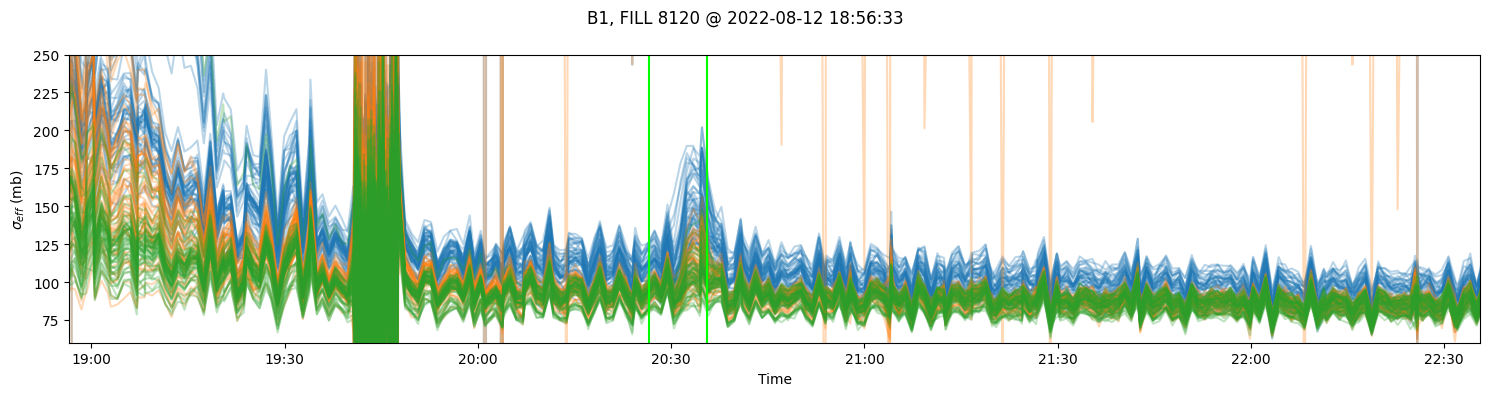

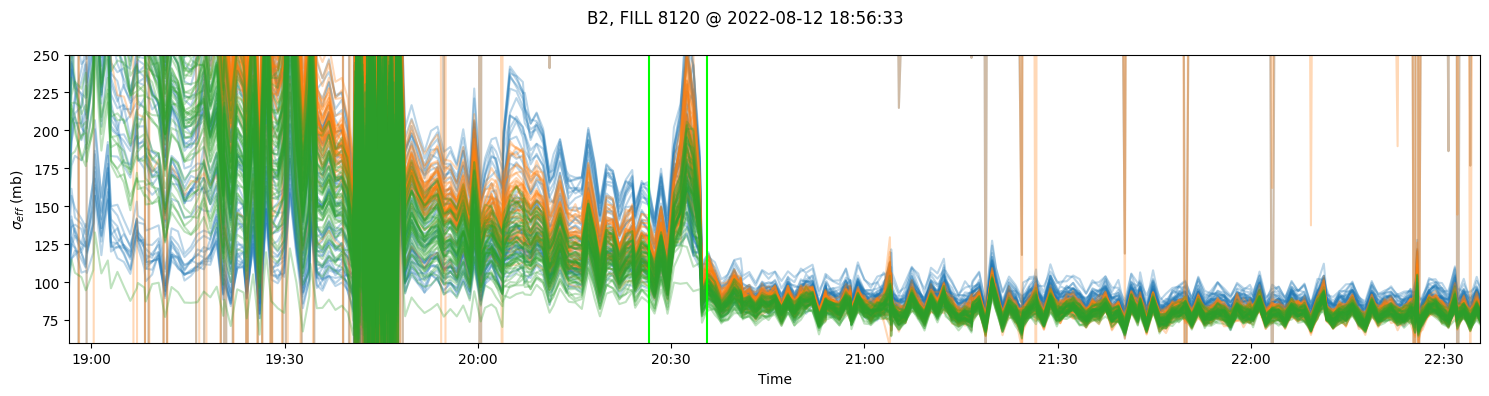

In [81]:

fills_info       = pd.read_pickle("wires_on.pkl")
fills_to_analyze = list(fills_info.index) 

fills_to_analyze =[8120]

for FILL in fills_to_analyze:
    print(FILL)
    plt.close('all')
    for beam in beams:
        fig = plt.figure(figsize=(15,4))

        # Importing some data for timescales
        #-----------------------------------
        database             = importData(FILL,columns=['HX:BMODE']+[wire.I for wire in wires['B1']+wires['B2']] + [beam['Intensity'] for beam in beams] + [beam['bb_Intensity'] for beam in beams])
        wire_start,wire_stop = wireROI(database)
        bunch_I              = getFilledBuckets(database,beam)
        filled_buckets = np.arange(len(buckets))[bunch_I!=0]

        start_ts = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
        stop_ts  = wire_stop+pd.Timedelta(hours=2)
        plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')
        #-----------------------------------
        
        # Loading Xsection
        #-----------------------------------
        lifetime_df = pd.read_pickle(f"../Results_Lumi_bb/pkl_per_fill/Xsection_F{FILL}_{beam.name}.pkl")    
        times,datagrid = lifetime_df.set_index('Timestamp')['sig_c'].to_2D()
        #-----------------------------------


        # Plotting
        #------------------------------------
        first_bunches = filled_buckets[1:][np.diff(filled_buckets)>1]
        last_bunches  = filled_buckets[:-1][np.diff(filled_buckets)>1]
        
        #datagrid = datagrid[:,filled_buckets]
        
 
        for bunch in first_bunches:
            plt.plot(times,datagrid[:,bunch]/1e-3,color='C0',alpha=0.3)

        for bunch in last_bunches:
            plt.plot(times,datagrid[:,bunch]/1e-3,color='C1',alpha=0.3)

        for bunch in first_bunches:
            plt.plot(times,datagrid[:,int(bunch+20)]/1e-3,color='C2',alpha=0.3)

        #plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/1e-3, norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='magma')
        plt.axvline(wire_start,color='lime')
        plt.axvline(wire_stop,color='lime')


        plt.ylabel(r'$\sigma_{eff}$ (mb)')
        plt.xlabel('Time')
        plt.xlim([start_ts,stop_ts])
        plt.ylim([60,250])

        plt.tight_layout()
        #plt.savefig(f'../Results_Lumi_bb/LBOC_plots/xsection_F{FILL}_{beam.name}.png',dpi=300)

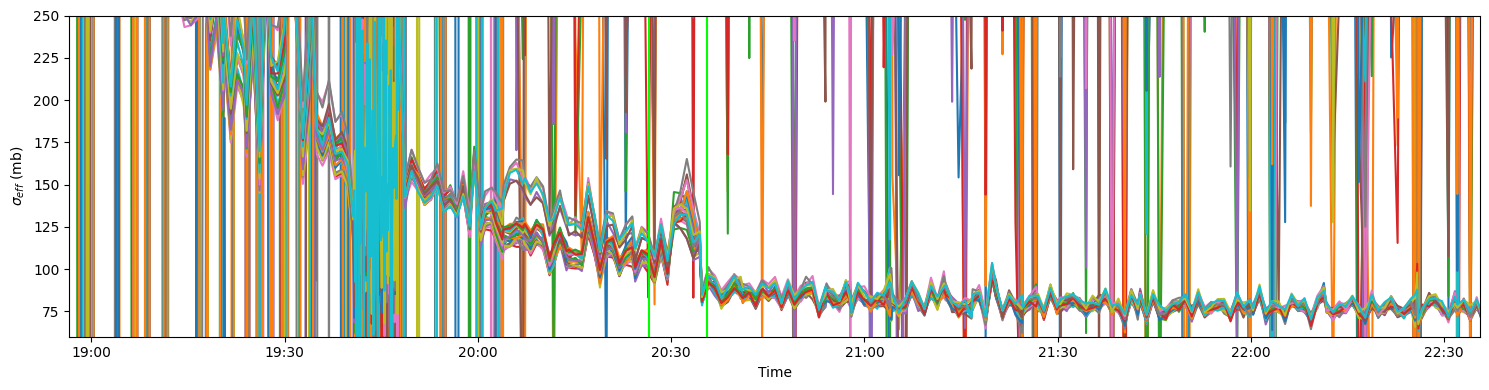

In [75]:
fig = plt.figure(figsize=(15,4))



for bunch in range(40):
    plt.plot(times,datagrid[:,bunch]/1e-3)

#plt.pcolormesh(times, np.arange(np.shape(datagrid)[1]), datagrid.T/1e-3, norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap='magma')
plt.axvline(wire_start,color='lime')
plt.axvline(wire_stop,color='lime')


plt.ylabel(r'$\sigma_{eff}$ (mb)')
plt.xlabel('Time')
plt.xlim([start_ts,stop_ts])
plt.ylim([60,250])

plt.tight_layout()

In [79]:
list(filled_buckets[1:][np.diff(filled_buckets)>1])

[114,
 169,
 224,
 279,
 334,
 413,
 468,
 523,
 578,
 633,
 712,
 767,
 822,
 877,
 932,
 1030,
 1085,
 1140,
 1195,
 1250,
 1329,
 1384,
 1439,
 1494,
 1549,
 1628,
 1683,
 1738,
 1793,
 1848,
 1927,
 1982,
 2037,
 2092,
 2147,
 2226,
 2281,
 2336,
 2391,
 2446,
 2735,
 2787,
 2842,
 2897,
 2952,
 3007,
 3086,
 3141,
 3196,
 3251,
 3306]